In [26]:
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from path import Path
from shutil import copy
from Bio import SeqIO, AlignIO, Phylo

## Input Parameters

In [27]:
# these are the columns to include in the metadata.csv output
meta_columns = ['sample_id', 'Virus name', 'Submitting lab', 'Location', 'Collection date', 'AVG_DEPTH', 'COVERAGE']

In [28]:
# path to reference sequence (used later for MSA and tree construction)
ref_path = Path('/home/gk/code/hCoV19/db/NC045512.fasta')

In [29]:
# this is the directory where results get saved
out_dir = Path('/home/al/data/covid_release_test')
# number of cores to use 
num_cpus = 8

In [30]:
# file path to samples sheet (make sure it is the most recent)
sample_sheet_fpath = '/home/al/code/covid/sequence_release/COVID_sequencing_summary - GISAID.csv'
# path to analysis results
analysis_fpath = '/home/gk/analysis/'
# file path to metadata of samples that have already been released
released_samples_fpath = '/home/al/code/covid/HCoV-19-Genomics/metadata.csv'

## Collecting Sequence Data

In [31]:
def get_ids(filepaths: list) -> list:
    "Utility function to get a unified sample ID format from the analysis file paths"
    ids = []
    for fp in filepaths:
        query = fp.basename().split('-')
        if len(query) > 1:
            ids.append(''.join(query[:2]))
        else:
            start_idx = fp.find('SEARCH')
            ids.append(fp[start_idx:start_idx+10])
    return ids

In [32]:
# grab all filepaths for bam data
bam_filepaths = !find {analysis_fpath} -type f -path '*merged_aligned_bams/illumina*' -name '*.bam'
bam_filepaths = [Path(fp) for fp in bam_filepaths]

In [33]:
# consolidate sample ID format
bam_ids = get_ids(bam_filepaths)

In [34]:
len(bam_filepaths), len(bam_ids)

(393, 393)

In [35]:
# Turn into dataframe
bam_data = list(zip(*[bam_ids, bam_filepaths]))

bam_df = pd.DataFrame(data=bam_data, columns=['sample_id', 'PATH'])

In [36]:
# grab all paths to consensus sequences
consensus_filepaths = !find {analysis_fpath} -type f -path '*consensus_sequences/illumina*' -name '*.fa'
consensus_filepaths = [Path(fp) for fp in consensus_filepaths]

In [37]:
# consolidate sample ID format
consensus_ids = get_ids(consensus_filepaths)

In [38]:
len(consensus_filepaths), len(consensus_ids)

(4404, 4404)

In [39]:
# Turn into dataframe
consensus_data = list(zip(*[consensus_ids, consensus_filepaths]))

consensus_df = pd.DataFrame(data=consensus_data, columns=['sample_id', 'PATH'])

In [40]:
# con

In [41]:
# clean up
bam_df.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
bam_df.shape

(388, 2)

In [42]:
# clean up
consensus_df.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
consensus_df.shape

(4356, 2)

In [43]:
# include only SEARCH samples
consensus_df = consensus_df[(consensus_df['sample_id'].str.contains('SEARCH'))]

In [44]:
# merge consensus and bam filepaths for each sample ID
analysis_df = pd.merge(consensus_df, bam_df, on='sample_id', how='left')
# exclude any samples that do not have BAM data
num_samples_missing_bams = analysis_df[analysis_df['PATH_y'].isna()].shape
# analysis_df = analysis_df[~analysis_df['PATH_y'].isna()]

In [45]:
# load sample sheet data (GISAID) - make sure to download most recent one 
seqsum = pd.read_csv(sample_sheet_fpath)

In [46]:
consensus_df

,sample_id,PATH
0,SEARCH3914,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
1,SEARCH3987,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
2,SEARCH3962,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
3,SEARCH4063,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
4,SEARCH4050,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
...,...,...
4399,SEARCH0171,/home/gk/analysis/2020.05.01.hCoV19/consensus_...
4400,SEARCH0147,/home/gk/analysis/2020.05.01.hCoV19/consensus_...
4401,SEARCH0166,/home/gk/analysis/2020.05.01.hCoV19/consensus_...
4402,SEARCH0161,/home/gk/analysis/2020.05.01.hCoV19/consensus_...


In [47]:
num_samples_missing_bams

(4328, 3)

In [48]:
# clean up
seqsum = seqsum[(~seqsum['SEARCH SampleID'].isna()) & (seqsum['SEARCH SampleID']!='#REF!')]

In [49]:
seqsum.shape

(4111, 34)

In [50]:
def process_id(x):
    "Utility function to process sample IDs to fix inconsistencies in the format"
    return ''.join(x.split('-')[:2])
# consolidate sample ID format
seqsum.loc[:, 'sample_id'] = seqsum['SEARCH SampleID'].apply(process_id)
# seqsum['sample_id']

In [51]:
seqsum.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
seqsum.shape

(4070, 35)

In [52]:
print(seqsum.shape)
seqsum = seqsum[seqsum['New sequences ready for release'] == 'Yes']
print(seqsum.shape)

(4070, 35)
(1205, 35)


In [53]:
sequence_results = pd.merge(seqsum, consensus_df, on='sample_id', how='inner')

print(sequence_results.shape)

(1205, 36)


In [55]:
sequence_results

,Sample ID,SEARCH SampleID,Ready for release?,New sequences ready for release,Released?,Submitter,FASTA filename,Virus name,Type,Passage details/history,...,Address,Sample ID given by the sample provider,Submitting lab,Address.1,Sample ID given by the submitting laboratory,Authors,Comment,Comment Icon,sample_id,PATH
0,20-046577-01,SEARCH-1996-SAN,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-1996-SAN/2020,betacoronavirus,Original,...,"3851 Rosecrans St., San Diego, CA, 92110",SEARCH-1996-SAN,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-1996-SAN,"SEARCH Alliance San Diego with Tracy Basler, J...",NaN,NaN,SEARCH1996,/home/gk/analysis/2020.08.10.hCoV19/consensus_...
1,20-044351-01,SEARCH-2004-SAN,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-2004-SAN/2020,betacoronavirus,Original,...,"3851 Rosecrans St., San Diego, CA, 92110",SEARCH-2004-SAN,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-2004-SAN,"SEARCH Alliance San Diego with Tracy Basler, J...",NaN,NaN,SEARCH2004,/home/gk/analysis/2020.08.10.hCoV19/consensus_...
2,20-044906-01,SEARCH-2005-SAN,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-2005-SAN/2020,betacoronavirus,Original,...,"3851 Rosecrans St., San Diego, CA, 92110",SEARCH-2005-SAN,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-2005-SAN,"SEARCH Alliance San Diego with Tracy Basler, J...",NaN,NaN,SEARCH2005,/home/gk/analysis/2020.08.10.hCoV19/consensus_...
3,20-046498-01,SEARCH-2010-SAN,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-2010-SAN/2020,betacoronavirus,Original,...,"3851 Rosecrans St., San Diego, CA, 92110",SEARCH-2010-SAN,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-2010-SAN,"SEARCH Alliance San Diego with Tracy Basler, J...",NaN,NaN,SEARCH2010,/home/gk/analysis/2020.08.10.hCoV19/consensus_...
4,20-046500-01,SEARCH-2011-SAN,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-2011-SAN/2020,betacoronavirus,Original,...,"3851 Rosecrans St., San Diego, CA, 92110",SEARCH-2011-SAN,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-2011-SAN,"SEARCH Alliance San Diego with Tracy Basler, J...",NaN,NaN,SEARCH2011,/home/gk/analysis/2020.08.10.hCoV19/consensus_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2069911,SEARCH-4094-JOR,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/JOR/SEARCH-4094-JOR/2020,betacoronavirus,Original,...,"Abdoun Clinics, Suleiman Hadidi street, 5th ci...",SEARCH-4094-JOR,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-4094-JOR,"Issa Abu-Dayyeh, Ahmad Tibi, Lama Hussein, Lin...",NaN,NaN,SEARCH4094,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
1201,2062946,SEARCH-4095-JOR,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/JOR/SEARCH-4095-JOR/2020,betacoronavirus,Original,...,"Abdoun Clinics, Suleiman Hadidi street, 5th ci...",SEARCH-4095-JOR,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-4095-JOR,"Issa Abu-Dayyeh, Ahmad Tibi, Lama Hussein, Lin...",NaN,NaN,SEARCH4095,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
1202,2063520,SEARCH-4096-JOR,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/JOR/SEARCH-4096-JOR/2020,betacoronavirus,Original,...,"Abdoun Clinics, Suleiman Hadidi street, 5th ci...",SEARCH-4096-JOR,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-4096-JOR,"Issa Abu-Dayyeh, Ahmad Tibi, Lama Hussein, Lin...",NaN,NaN,SEARCH4096,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
1203,2064504,SEARCH-4097-JOR,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/JOR/SEARCH-4097-JOR/2020,betacoronavirus,Original,...,"Abdoun Clinics, Suleiman Hadidi street, 5th ci...",SEARCH-4097-JOR,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-4097-JOR,"Issa 

In [57]:
# num_samples_missing_bams = sequence_results[sequence_results['PATH_y'].isna()].shape[0]
num_samples_missing_cons = sequence_results[sequence_results['PATH'].isna()].shape[0]

print(num_samples_missing_bams)
print(num_samples_missing_cons)

(4328, 3)
0


## Make sure to remove any samples that have already been uploaded to github (just an extra safety step)

In [58]:
# load metadata.csv from github repo, then clean up
meta_df = pd.read_csv(released_samples_fpath)
print(meta_df.shape)
meta_df = meta_df[meta_df['ID'].str.contains('SEARCH')]
print(meta_df.shape)

(1195, 9)
(1193, 9)


In [59]:
# consolidate sample ID format
meta_df.loc[:, 'sample_id'] = meta_df['ID'].apply(process_id)
# meta_df['sample_id']

In [60]:
# get IDs of samples that have already been released
released_seqs = meta_df['sample_id'].unique()

In [61]:
# filter out released samples from all the samples we got
final_result = sequence_results#[~sequence_results['sample_id'].isin(released_seqs)]
print(final_result.shape)

(1205, 36)


In [69]:
final_result['loc'] = final_result['Location'].apply(lambda x: x.split('/')[0])
jor_cns_filepaths = final_result.loc[(final_result['loc']=='JOR') & (final_result['Ready for release?']=='Yes')]

In [71]:
def transfer_files(filepaths: pd.DataFrame, destination: str, include_bams=False):
    "Utility function to copy consensus and BAM files of given samples dataframe"
    filepaths = filepaths['PATH']
    destination = Path(destination)
    if not Path.isdir(destination):
        Path.mkdir(destination);
        Path.mkdir(destination/'fa/')
        Path.mkdir(destination/'bam/')
    for fp in filepaths.values:
        cons_fp = fp
        copy(cons_fp, destination/'fa/')
        if include_bams:
            copy(bam_fp, destination/'bam/')
    return 0
transfer_files(jor_cns_filepaths, '/home/al/data/jordan')

0

In [72]:
out_dir = '/home/al/data/jordan'

In [43]:
def compress_files(filepaths: list, destination='/home/al/tmp2/fa/samples.tar.gz'):
    "Utility function to compress list of files into a single .tar.gz file"
    with tarfile.open(destination, "w:gz") as tar:
        for f in filepaths:
            tar.add(f)
    return 0

In [44]:
# t = Path('/home/al/tmp2/fa/').listdir()
# compress_files(t)

## Getting coverage information

In [77]:
cov_filepaths = !find {analysis_fpath} -type f -path '*trimmed_bams/illumina/reports*' -name '*.tsv'
cov_filepaths = [Path(fp) for fp in cov_filepaths]

In [78]:
cov_df = pd.concat((pd.read_csv(f, sep='\t').assign(path=f) for f in cov_filepaths))

In [79]:
cov_df.head()

,SAMPLE,COVERAGE,AVG_DEPTH,MIN,MAX,ZERO_DEPTH,path
0,SEARCH-3924-JOR_L001_L002_L003_L004.trimmed.so...,0.0000,0.10592,0,3,26828,/home/gk/analysis/2020.10.27.hCoV19/trimmed_ba...
1,SEARCH-4030-JOR_L001_L002_L003_L004.trimmed.so...,98.0618,3657.67000,0,8007,52,/home/gk/analysis/2020.10.27.hCoV19/trimmed_ba...
2,SEARCH-4029-JOR_L001_L002_L003_L004.trimmed.so...,98.7113,4270.41000,1,8009,0,/home/gk/analysis/2020.10.27.hCoV19/trimmed_ba...
3,SEARCH-3998-JOR_L001_L002_L003_L004.trimmed.so...,99.0445,4397.36000,1,8005,0,/home/gk/analysis/2020.10.27.hCoV19/trimmed_ba...
4,SEARCH-4066-JOR_L001_L002_L003_L004.trimmed.so...,99.3777,751.40400,5,5517,0,/home/gk/analysis/2020.10.27.hCoV19/trimmed_ba...


In [80]:
def process_coverage_sample_ids(x):
    "Utility function to get a unified sample ID format from the coverage reports"
    query = x.split('/')
    if len(query) == 1:
        return ''.join(x.split('-')[:2])
    else:
        start_idx = x.find('SEARCH')
        return x[start_idx:start_idx+10]
        
cov_df['sample_id'] = cov_df['SAMPLE'].apply(process_coverage_sample_ids)
cov_df['date'] = cov_df['path'].apply(lambda x: ''.join(x.split('/')[4].split('.')[:3]))

In [49]:
cov_df = (cov_df.sort_values('date')
          .drop_duplicates(subset=['sample_id'], keep='last'))
cov_df.shape

(3955, 9)

In [50]:
ans = pd.merge(final_result, cov_df, on='sample_id')[meta_columns]
ans.head()

,sample_id,Virus name,Submitting lab,Location,Collection date,AVG_DEPTH,COVERAGE
0,SEARCH1996,hCoV-19/USA/SEARCH-1996-SAN/2020,Andersen lab at Scripps Research,USA/California/San Diego,2020-05-14,3034.85,100.0
1,SEARCH2004,hCoV-19/USA/SEARCH-2004-SAN/2020,Andersen lab at Scripps Research,USA/California/San Diego,2020-05-08,8832.41,100.0
2,SEARCH2005,hCoV-19/USA/SEARCH-2005-SAN/2020,Andersen lab at Scripps Research,USA/California/San Diego,2020-05-12,2054.16,100.0
3,SEARCH2010,hCoV-19/USA/SEARCH-2010-SAN/2020,Andersen lab at Scripps Research,USA/California/San Diego,2020-05-14,2441.08,100.0
4,SEARCH2011,hCoV-19/USA/SEARCH-2011-SAN/2020,Andersen lab at Scripps Research,USA/California/San Diego,2020-05-14,5040.19,100.0


In [51]:
ans.to_csv(out_dir/'metadata.csv', index=False)

## Data Logging

In [53]:
low_coverage_samples = ans[ans['COVERAGE'] < 90]

In [74]:
with open(f'{out_dir}/data_release.log', 'w') as f:
    f.write(f'{low_coverage_samples.shape[0]} samples were found to have coverage below 90%\n')
    f.write(f'{num_samples_missing_cons} samples were ignored because they were missing consensus sequence files\n')
    f.write(f'{num_samples_missing_bams} samples were ignored because they were missing BAM sequence files\n')

## Renaming Samples

In [74]:
out_dir = Path(out_dir)

In [75]:
cons_seqs = Path(out_dir/'fa')

In [82]:
sampleid2name = pd.Series(jor_cns_filepaths['Virus name'].values,index=jor_cns_filepaths['sample_id']).to_dict()

In [84]:
# sampleid2name.get(sample_id, 'NA')
sampleid2name

{'SEARCH2578': 'hCoV-19/JOR/SEARCH-2578-JOR/2020',
 'SEARCH2579': 'hCoV-19/JOR/SEARCH-2579-JOR/2020',
 'SEARCH2581': 'hCoV-19/JOR/SEARCH-2581-JOR/2020',
 'SEARCH2583': 'hCoV-19/JOR/SEARCH-2583-JOR/2020',
 'SEARCH2585': 'hCoV-19/JOR/SEARCH-2585-JOR/2020',
 'SEARCH2586': 'hCoV-19/JOR/SEARCH-2586-JOR/2020',
 'SEARCH3901': 'hCoV-19/JOR/SEARCH-3901-JOR/2020',
 'SEARCH3902': 'hCoV-19/JOR/SEARCH-3902-JOR/2020',
 'SEARCH3903': 'hCoV-19/JOR/SEARCH-3903-JOR/2020',
 'SEARCH3904': 'hCoV-19/JOR/SEARCH-3904-JOR/2020',
 'SEARCH3905': 'hCoV-19/JOR/SEARCH-3905-JOR/2020',
 'SEARCH3906': 'hCoV-19/JOR/SEARCH-3906-JOR/2020',
 'SEARCH3907': 'hCoV-19/JOR/SEARCH-3907-JOR/2020',
 'SEARCH3908': 'hCoV-19/JOR/SEARCH-3908-JOR/2020',
 'SEARCH3909': 'hCoV-19/JOR/SEARCH-3909-JOR/2020',
 'SEARCH3910': 'hCoV-19/JOR/SEARCH-3910-JOR/2020',
 'SEARCH3911': 'hCoV-19/JOR/SEARCH-3911-JOR/2020',
 'SEARCH3912': 'hCoV-19/JOR/SEARCH-3912-JOR/2020',
 'SEARCH3913': 'hCoV-19/JOR/SEARCH-3913-JOR/2020',
 'SEARCH3914': 'hCoV-19/JOR/SEA

In [85]:
renamed_dir = out_dir/'fa_renamed'
def rename_fasta_headers(renamed_dir: str=renamed_dir):
    """A Utility function to rename the headers of each consensus sequence"""
    if not Path.isdir(renamed_dir):
        Path.mkdir(renamed_dir);
    for seq_path in cons_seqs.listdir():
        with open(seq_path, 'r') as f:
            records = SeqIO.parse(f, 'fasta')
            for record in records:
                sample_id = ''.join(record.id.split('_')[1].split('-')[:2])
                sample_name = sampleid2name.get(sample_id, 'NA').split('/')[2]
                record.id = sample_name
                record.description = sample_name
                SeqIO.write(record, renamed_dir/seq_path.basename(), 'fasta')
    return 0
rename_fasta_headers(renamed_dir)

0

## Multiple Sequence Alignment

In [86]:
cons_seqs = Path(out_dir/'fa_renamed')

In [87]:
copy(ref_path, cons_seqs)

Path('/home/al/data/jordan/fa_renamed/NC045512.fasta')

In [88]:
msa_dir = out_dir/'msa'
if not Path.isdir(msa_dir):
    Path.mkdir(msa_dir);

In [90]:
num_cpus = 20

In [91]:
!cat {cons_seqs}/*.fa* > all_seqs_merged.fa
!mafft --auto --thread {num_cpus} all_seqs_merged.fa > {msa_dir}/msa.fa
!rm all_seqs_merged.fa

nthread = 20
nthreadpair = 20
nthreadtb = 16
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 11483 ambiguous characters.
  201 / 204 (thread   14)
done.

Constructing a UPGMA tree (efffree=0) ... 
  200 / 204
done.

Progressive alignment 1/2... 
STEP   203 / 203 (thread    0)
done.

Making a distance matrix from msa.. 
  200 / 204 (thread   10)
done.

Constructing a UPGMA tree (efffree=1) ... 
  200 / 204
done.

Progressive alignment 2/2... 
STEP   203 / 203 (thread   15)
done.

disttbfast (nuc) Version 7.464
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
16 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has bee

In [92]:
!ls {out_dir}

bam  fa  fa_renamed  msa


## Tree Construction

In [93]:
!iqtree -s {msa_dir}/msa.fa -T {num_cpus} -m TEST -czb

IQ-TREE multicore version 2.0.3 for Linux 64-bit built Apr 26 2020
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor,
Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Host:    cartman (AVX2, FMA3, 125 GB RAM)
Command: iqtree -s /home/al/data/jordan/msa/msa.fa -T 20 -m TEST -czb
Seed:    730440 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Wed Nov 18 18:21:23 2020
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Kernel:  AVX+FMA - 20 threads (32 CPU cores detected)

Reading alignment file /home/al/data/jordan/msa/msa.fa ... Fasta format detected
Alignment most likely contains DNA/RNA sequences
Alignment has 204 sequences with 29903 columns, 378 distinct patterns
160 parsimony-informative, 120 singleton sites, 29623 constant sites
                 Gap/Ambiguity  Composition  p-value
   1  NC_045512.2        0.00%    passed     99.88%
   2  SEARCH-2578-JOR    0.30%    passed     99.94%
   3  SEARCH-2579-JOR



Create initial parsimony tree by phylogenetic likelihood library (PLL)... 0.018 seconds
Perform fast likelihood tree search using GTR+I+G model...
Estimate model parameters (epsilon = 5.000)
Perform nearest neighbor interchange...
Estimate model parameters (epsilon = 1.000)
1. Initial log-likelihood: -43676.183
Optimal log-likelihood: -43676.180
Rate parameters:  A-C: 0.17047  A-G: 0.64039  A-T: 0.10411  C-G: 0.07698  C-T: 2.80261  G-T: 1.00000
Base frequencies:  A: 0.299  C: 0.183  G: 0.196  T: 0.321
Proportion of invariable sites: 0.496
Gamma shape alpha: 0.020
Parameters optimization took 1 rounds (0.039 sec)
Time for fast ML tree search: 0.549 seconds

NOTE: ModelFinder requires 10 MB RAM!
ModelFinder will test up to 88 DNA models (sample size: 29903) ...
 No. Model         -LnL         df  AIC          AICc         BIC
  1  GTR+F         43697.232    413 88220.464    88232.061    91650.724
  2  GTR+F+I       43676.092    414 88180.184    88191.837    91618.750
  3  GTR+F+G4     

 75  HKY+F+G4      43769.762    410 88359.523    88370.951    91764.866
 78  K2P+I         44711.577    407 90237.154    90248.414    93617.580
 79  K2P+G4        44718.484    407 90250.969    90262.229    93631.395
 82  F81+F+I       43856.004    409 88530.007    88541.379    91927.044
 83  F81+F+G4      43861.613    409 88541.226    88552.597    91938.263
 86  JC+I          44797.207    406 90406.415    90417.619    93778.535
 87  JC+G4         44804.109    406 90420.217    90431.421    93792.337
Akaike Information Criterion:           GTR+F+I
Corrected Akaike Information Criterion: GTR+F+I
Bayesian Information Criterion:         GTR+F+I
Best-fit model: GTR+F+I chosen according to BIC

All model information printed to /home/al/data/jordan/msa/msa.fa.model.gz
CPU time for ModelFinder: 60.960 seconds (0h:1m:0s)
Wall-clock time for ModelFinder: 3.510 seconds (0h:0m:3s)

NOTE: 2 MB RAM (0 GB) is required!
Estimate model parameters (epsilon = 0.100)
1. Initial log-likelihood: -43676.092
O

## Tree Visualization

In [105]:
tree_path = f"{msa_dir/'msa.fa'}.treefile"
tree = next(Phylo.parse(tree_path, 'newick'))
print(tree.rooted)
# root with genome from patient zero
root_name = 'NC_045512.2'
tree.root_with_outgroup(root_name)
print(tree.rooted)

False
True


In [106]:
def get_coords(tree):
    for _i, i in enumerate(tree.get_terminals()):
        i.y = _i
        i.x = tree.distance(i)

    for i in reversed(tree.get_nonterminals()):
        _ = i.clades
        i.y = (_[0].y + _[-1].y)/2
        i.x = tree.distance(i)
    return tree
tree = get_coords(tree)

In [104]:
sample_colors = {}

In [100]:
# ans['sample_name'] = ans['Virus name'].apply(lambda x : x.split('/')[2])
# ans

In [99]:
ans['loc'] = ans['sample_name'].apply(lambda x : x.split('-')[-1])
locs = ans['loc'].unique()

In [101]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
          '#bcf60c', '#fabebe', '#008080', '#e6beff']
len(colors)

12

In [102]:
sample_colors = {x: y for x, y in zip(locs, colors)}

In [106]:
legend_elements = [Line2D([0], [0], marker='o', color=x, label=y,
                   markerfacecolor=x, markersize=15) for y, x in sample_colors.items()]

In [108]:
viz_dir = out_dir/'viz'
if not Path.isdir(viz_dir):
    Path.mkdir(viz_dir);

In [114]:
plt.rcParams["figure.figsize"] = (20,60)

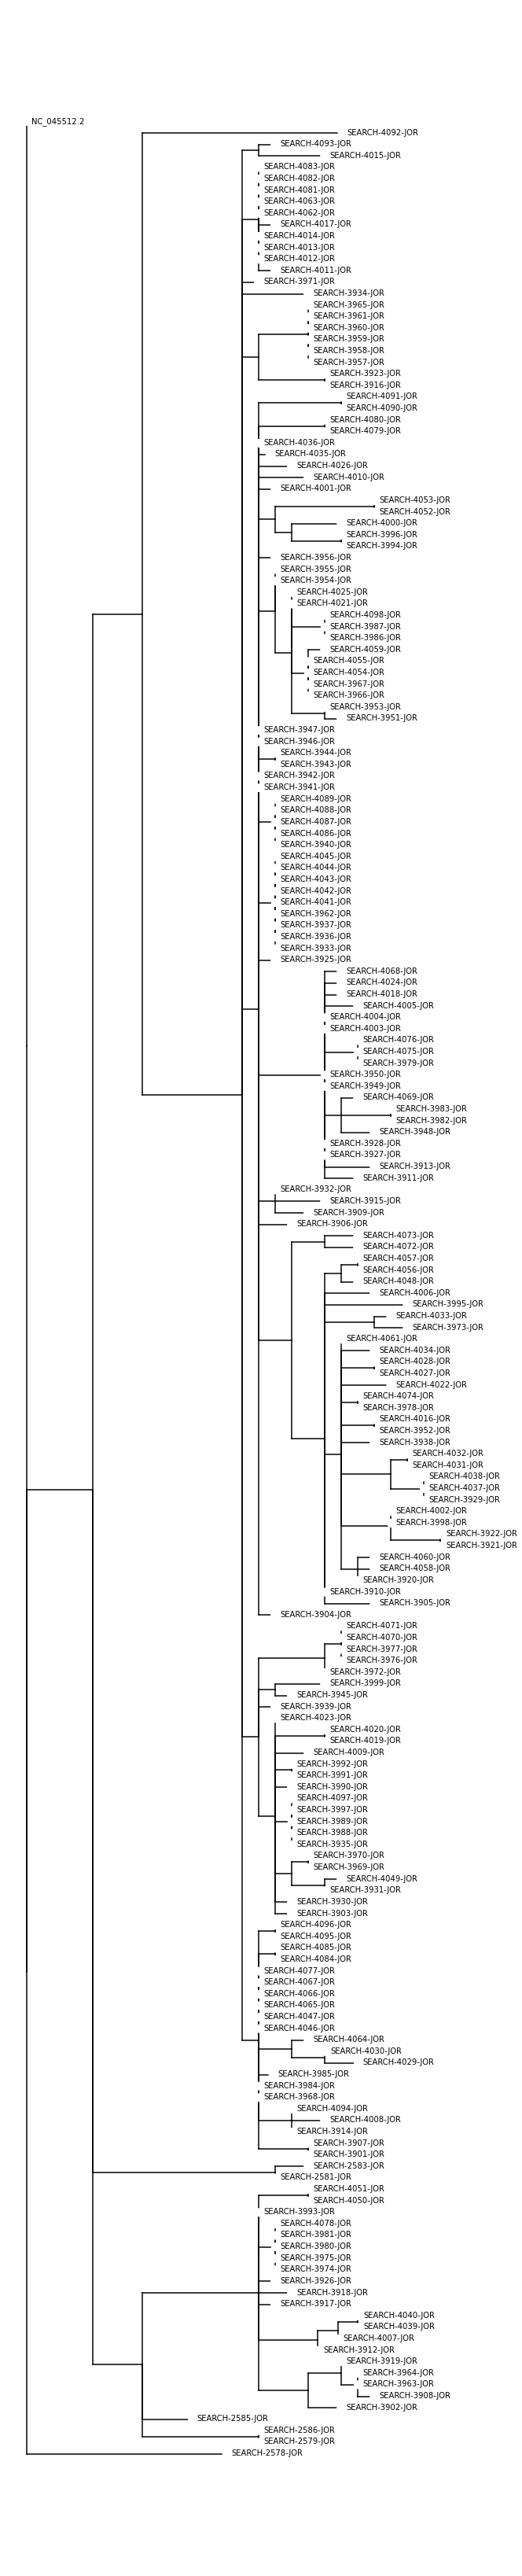

In [117]:
f = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.75], height_ratios = [0.5,0.5])

ax = plt.subplot(gs[:,0])
for i in tree.get_nonterminals():
    for j in i.clades:
#         if prune_clade(j, deletion_samples): continue
        _t = ax.plot([i.x, i.x], [i.y, j.y], ls='-', color="#000000", zorder = 1)
        _t = ax.plot([i.x, j.x], [j.y, j.y], ls='-', color="#000000", zorder = 1)
        
_ = {
    "x": [],
    "y": [],
    "c": []
}
for i in tree.get_terminals():
    _["x"].append(i.x)
    _["y"].append(i.y)
    _["c"].append(sample_colors.get(i.name, 'white'))
    
    ax.text(i.x+1e-5, i.y-1e-1, i.name)
#     _["c"].append(c)
    # ax.text(i.x+0.001, i.y, i.name.split("_")[3])
    # if i.name in hp["taxon name"].tolist():
    #     ax.text(i.x + 0.000025, i.y, i.name.split("_")[0] + " " + str(hp[hp["taxon name"] == i.name]["#of homoplasic mutations"].values[0]))
# ax.text(_["x"], _["y"], _["text"])
ax.scatter(_["x"], _["y"], c = _["c"], s = 100, zorder = 2)
ax.scatter(_["x"], _["y"], c = _["c"], s = 50, zorder = 2)
# ax.legend(handles=legend)
f.patch.set_visible(False)
ax.axis('off')
plt.show()

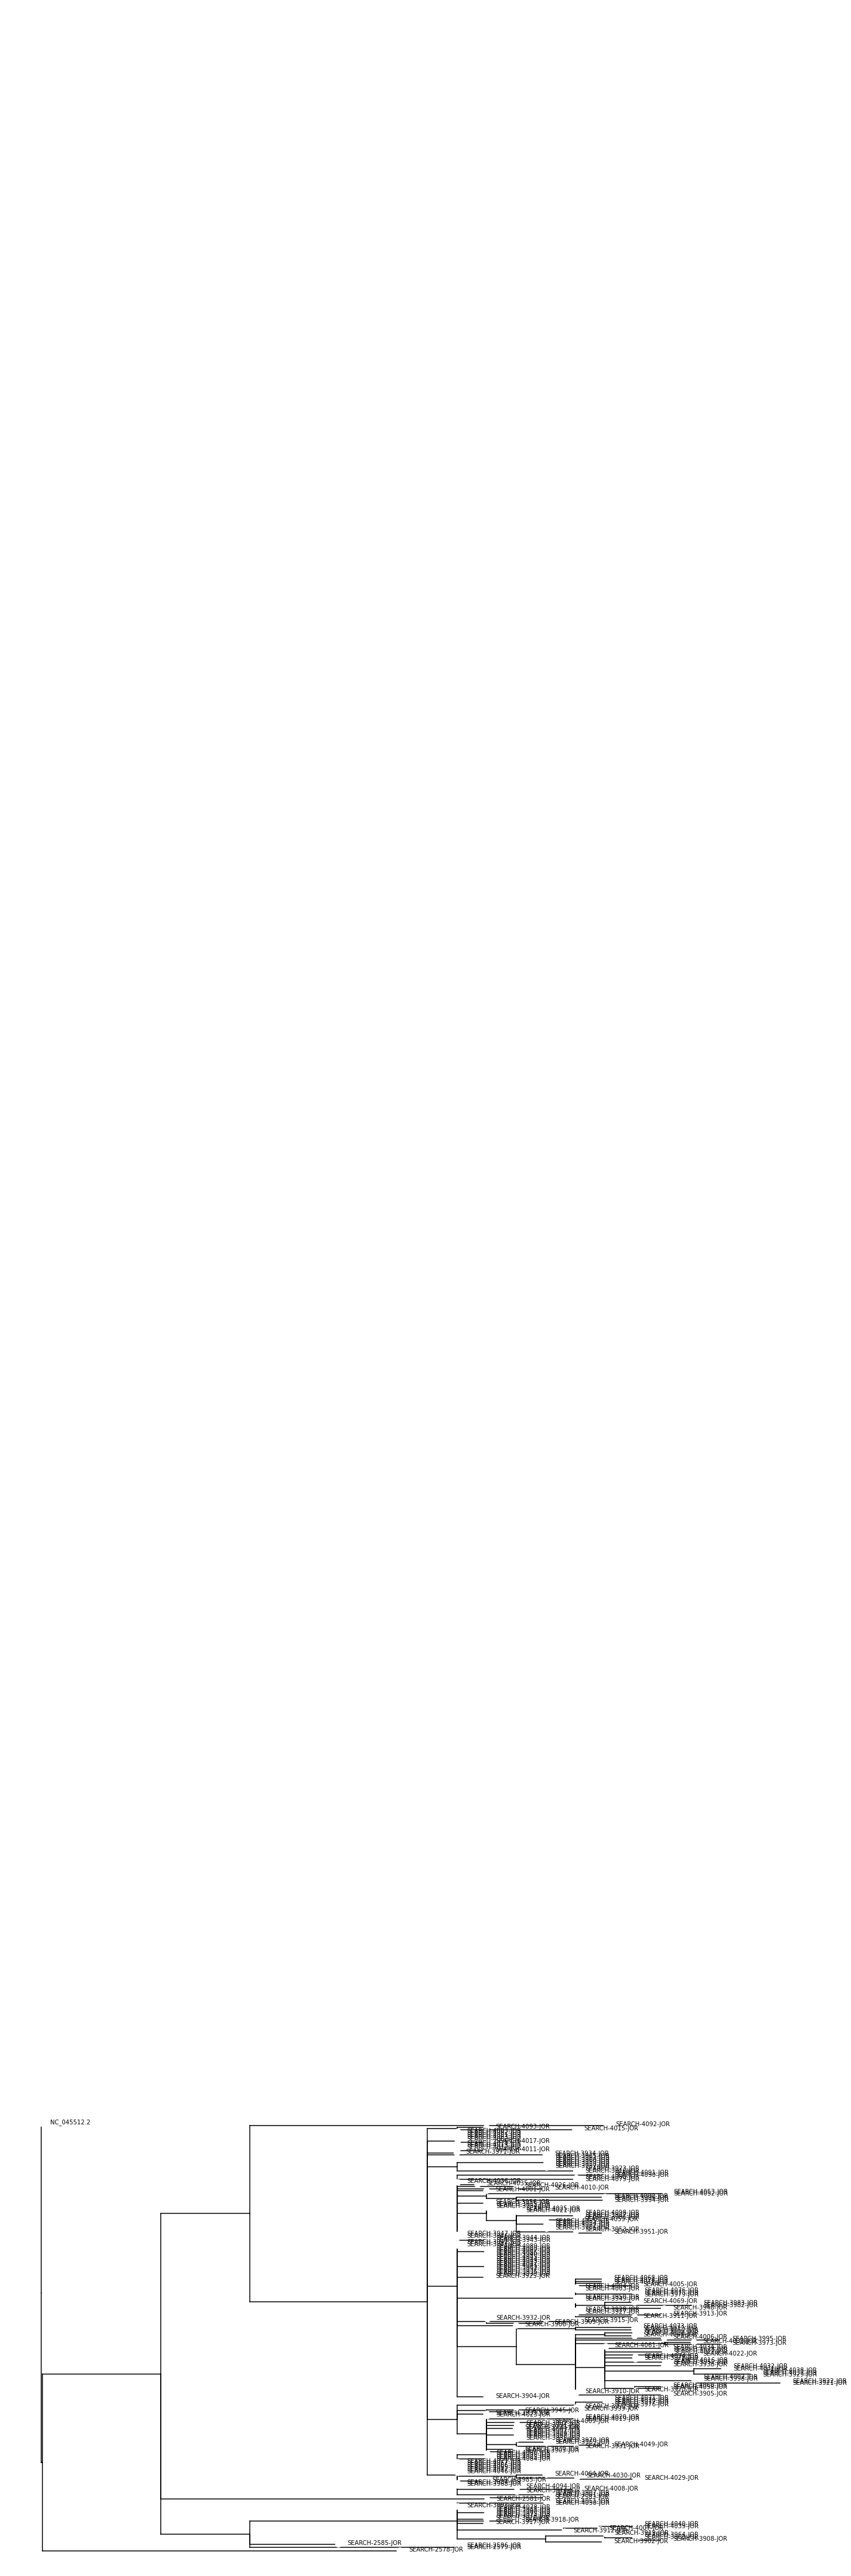

In [115]:
f = plt.figure()
# gs = gridspec.GridSpec(1, 1)

ax = plt.subplot()
for i in tree.get_nonterminals():
    for j in i.clades:
        _t = ax.plot([i.x, i.x], [i.y, j.y], ls='-', color="#000000", zorder = 1)
        _t = ax.plot([i.x, j.x], [j.y, j.y], ls='-', color="#000000", zorder = 1)

term_data = {
    "x": [],
    "y": [],
    "c": []
}
for i in tree.get_terminals():
    term_data["x"].append(i.x)
    term_data["y"].append(i.y)
    loc = i.name.split('-')[-1]
    term_data["c"].append(sample_colors.get(loc, 'white'))
    
    ax.text(i.x+1e-5, i.y-1e-1, i.name)

ax.scatter(term_data["x"], term_data["y"], c = term_data["c"], s = 100, zorder = 2)
ax.scatter(term_data["x"], term_data["y"], c = term_data["c"], s = 50, zorder = 2)
# ax.legend(handles=legend_elements)
f.patch.set_visible(False)
plt.ylim(bottom=-10, top=1210)
ax.axis('off')
plt.savefig(viz_dir/'jordan_tree.pdf', bbox_inches='tight')
plt.tight_layout()

# Developmental Code [burn after reading]

## TODO
* generate multiple sequence alignment (msa) of consensus sequences 
* generate treefile from msa
* generate color-coded trees with following filters
    * color
    * location
    * indels
* include all metadata from GISAID sheet and write to `metadata.csv`[done]
* grab coverage metrics and tag into metadata [done]
* add step to get inputs from online docs
* refactor code into `clean` and `developmental`
* create test set [done]
    * test = (analysis & sample_sheet) - metadata.csv (from: github.com/andersen-lab/HCoV-19-Genomics)
* copy from source to destination path [done]
* if destination does not exist, create it [done]
* define compress() that takes list of filenames and compresses those files using tarFile [done]

In [181]:
consensus_df.shape

(3812, 2)

In [88]:
consensus_df[consensus_df.duplicated(subset=['sample_id'], keep='last')].sort_values('sample_id').tail().values

array([['SEARCH1988',
        Path('/home/gk/analysis/2020.07.27.hCoV19/consensus_sequences/illumina/SEARCH-1988-SAN_L001_L002_L003_L004.fa')],
       ['SEARCH1989',
        Path('/home/gk/analysis/2020.07.27.hCoV19/consensus_sequences/illumina/SEARCH-1989-SAN_L001_L002_L003_L004.fa')],
       ['SEARCH1990',
        Path('/home/gk/analysis/2020.07.27.hCoV19/consensus_sequences/illumina/SEARCH-1990-SAN_L001_L002_L003_L004.fa')],
       ['SEARCH1991',
        Path('/home/gk/analysis/2020.07.27.hCoV19/consensus_sequences/illumina/SEARCH-1991-SAN_L001_L002_L003_L004.fa')],
       ['SEARCH1992',
        Path('/home/gk/analysis/2020.07.27.hCoV19/consensus_sequences/illumina/SEARCH-1992-SAN_L001_L002_L003_L004.fa')]],
      dtype=object)

In [89]:
consensus_df.shape

(3812, 2)

In [222]:
# consensus_df

In [91]:
# consensus_df[consensus_df.duplicated(subset=['ID'], keep=False)]

In [92]:
# consensus_df[consensus_df['ID']=='SEARCH0247'].values

In [117]:
tmp.shape

(1890, 3)

**FINDING**: there is a significant number of duplicate consensus sequences inside the `analysis` directory. 
**SOLUTION**: keep most recent ones only

In [107]:
seqsum = pd.read_csv("COVID_sequencing_summary - GISAID.csv")

In [108]:
duplicated = seqsum[(seqsum.duplicated(subset=['SEARCH SampleID'], keep=False)) & (~seqsum['SEARCH SampleID'].isna())]
# duplicated['SEARCH SampleID'].value_counts()

In [109]:
seqsum.shape

(3397, 33)

In [110]:
seqsum = seqsum[(~seqsum['SEARCH SampleID'].isna()) & (seqsum['SEARCH SampleID']!='#REF!')]

In [111]:
seqsum.shape

(3373, 33)

In [112]:
s = 'SEARCH-0003-SAN'
''.join(s.split('-')[:2])

'SEARCH0003'

In [113]:
def test_format(x):
    if len(x.split('-'))!=3:
        return True
    return False
seqsum['flags'] = seqsum['SEARCH SampleID'].apply(test_format)
# seqsum[seqsum['flags']==True]

In [171]:
def process_id(x):
    return ''.join(x.split('-')[:2])
seqsum.loc[:, 'sample_id'] = seqsum['SEARCH SampleID'].apply(process_id)
# seqsum['sample_id']

In [119]:
seqsum.shape

(3373, 35)

In [121]:
seqsum.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
seqsum.shape

(3342, 35)

In [123]:
sequence_results = pd.merge(seqsum, tmp, on='sample_id', how='inner')

In [125]:
meta_df = pd.read_csv('../HCoV-19-Genomics/metadata.csv')
print(meta_df.shape)
meta_df = meta_df[meta_df['ID'].str.contains('SEARCH')]
print(meta_df.shape)

(1195, 9)
(1193, 9)


In [170]:
meta_df.loc[:, 'sample_id'] = meta_df['ID'].apply(process_id)
# meta_df['sample_id']

In [128]:
released_seqs = meta_df['sample_id'].unique()

In [169]:
# released_seqs

In [168]:
# sequence_results['sample_id']

In [140]:
final_result = sequence_results[~sequence_results['sample_id'].isin(released_seqs)]

In [142]:
t = final_result[['PATH_x', 'PATH_y']]

In [155]:
def transfer_files(filepaths: pd.DataFrame, destination: str, include_bams=False):
    filepaths = filepaths[['PATH_x', 'PATH_y']]
    destination = Path(destination)
    if not Path.isdir(destination):
        Path.mkdir(destination);
        Path.mkdir(destination/'fa/')
        Path.mkdir(destination/'bam/')
    for fp in t.values:
        cons_fp, bam_fp = fp[0], fp[1]
        copy(cons_fp, destination/'fa/')
        if include_bams:
            copy(bam_fp, destination/'bam/')
    return 0
transfer_files(final_result, '/home/al/tmp2')

0

In [166]:
def compress_files(filepaths: list, destination='/home/al/tmp2/fa/samples.tar.gz'):
    with tarfile.open(destination, "w:gz") as tar:
        for f in filepaths:
            tar.add(f)
    return 0

In [167]:
t = Path('/home/al/tmp2/fa/').listdir()
compress_files(t)

0

In [51]:
for x in seqsum['SEARCH SampleID'].unique():
    if type(x) == float or len(x.split('-')) <= 1:
        print(x)

In [52]:
len(sample_seqs['SEARCH SampleID'])

NameError: name 'sample_seqs' is not defined

In [6]:
len(sample_seqs['SEARCH SampleID'].unique())

994

In [7]:
sample_seqs[sample_seqs.duplicated(subset=['SEARCH SampleID'], keep=False)]

,Sample ID,SEARCH SampleID,Ready for release?,Released?,Submitter,FASTA filename,Virus name,Type,Passage details/history,Collection date,...,Coverage,Originating lab,Address,Sample ID given by the sample provider,Submitting lab,Address.1,Sample ID given by the submitting laboratory,Authors,Comment,Comment Icon
2,MG-0987,SEARCH-0002-SAN,Yes,Yes,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-0002-SAN/2020,betacoronavirus,Original,2020-03-18,...,2465.6,Rady's Childrens Hospital,"3020 Children's Way, San Diego, CA 92123",SEARCH-0002-SAN,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-0002-SAN,SEARCH Alliance San Diego with Christina Clark...,NaN,NaN
3393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MG-0987,SEARCH-0002-SAN,Yes,Yes,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-0002-SAN/2020,betacoronavirus,Original,2020-03-18,...,NaN,Rady's Childrens Hospital,"3020 Children's Way, San Diego, CA 92123",SEARCH-0002-SAN,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",SEARCH-0002-SAN,SEARCH Alliance San Diego with Christina Clark...,,NaN
3385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2625,#REF!,#REF!,Don't release,NaN,Karthik Gangavarapu,NaN,#REF!,betacoronavirus,Original,#REF!,...,NaN,NaN,NaN,#REF!,Andersen lab at Scripps Research,"10550 North Torrey Pines Road, La Jolla, CA 92037",#REF!,FALSE,NaN,NaN
3363,#REF!,#REF!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#REF!,...,NaN,NaN,NaN,NaN,NaN,NaN,#REF!,NaN,NaN,NaN
